# Audio Recoginition 4C16/5C16 Project

---



## Audio Content & Gender Classification

#### About the dataset

The dataset consists of 25k audio tracks. Each of the audio track records the waveform of an audio recording of a human reading out digit (ie. from 0-9). Your task is to train two classification neural networks that **identify the digit** that has been uttered and **identify the gender**.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *input.npy*
    - *gender.npy*
    - *digit.npy*

The *input.npy* has a shape of (25000, 8000) which indicates 25000 waveforms and 8000 samples from each waveform. Each waveform is normalised with 1 second duration and 8 kHz sampling frequnecy. The *gender.npy* and *digit.npy* files contains the correspondent target information of the 25000 waveforms in the same order.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/4c16-labs/code/lab-07/

Mounted at /content/drive
/content/drive/MyDrive/4c16-labs/code/lab-07


In [ ]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/audiowavform-dataset.tar.xz https://tcddeeplearning.blob.core.windows.net/deeplearning202324/audiowavform-dataset.tar.xz
# Extract the dataset
!mkdir /home/tcd/data/audiowavform
!tar -xvf /home/tcd/data/audiowavform-dataset.tar.xz -C /home/tcd/data/audiowavform

# Dataset location: /home/tcd/data/audiowavform/public

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  108M  100  108M    0     0  7633k      0  0:00:14  0:00:14 --:--:-- 9325k
public/
public/ytrain_num.npy
public/ytrain_gender.npy
public/xtrain.npy


In [ ]:
import os
import scipy
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import keras
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from matplotlib.ticker import MaxNLocator
import tensorflow.keras as keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

In [ ]:
# loading the datasets in memory

dataset_path = '/home/tcd/data/audiowavform/public'

# xtrain  : numpy array of size n x 8000 which contains the waveforms for each of the 25k audio files.
x = np.load(f'{dataset_path}/xtrain.npy')

# y_num   : numpy array of size n x 10 which contains the digits (as one-hot encoding of the 10 categories) for each of the 25k audio files.
y_num = np.argmax(np.load(f'{dataset_path}/ytrain_num.npy'), axis=-1)

# y_gender: numpy array of size n x 2 which contains the gender (as one-hot encoding of the 2 categories) for each of the 25k audio files.
y_gender = np.argmax(np.load(f'{dataset_path}/ytrain_gender.npy'), axis=-1)


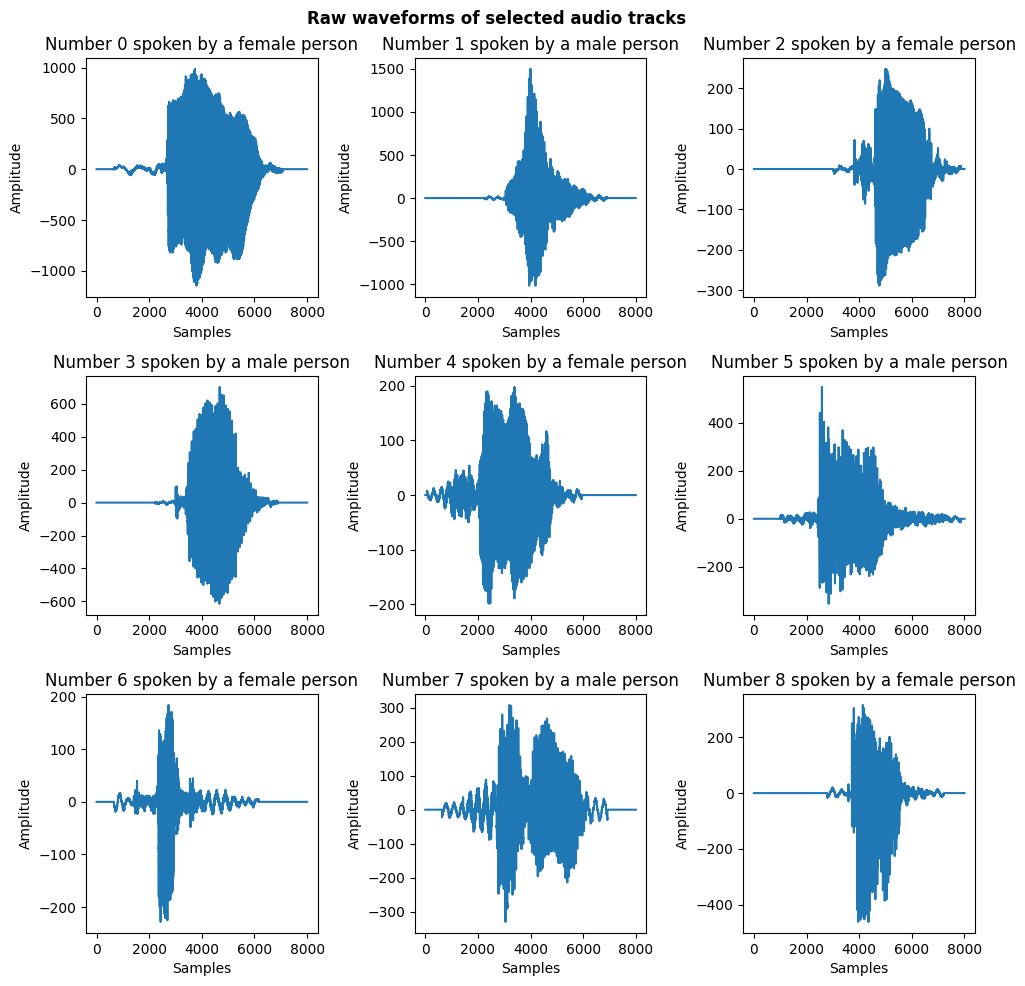

In [ ]:
# let's look at the data.
# The code below takes the same samples for the 0-9 digits by females and males
# and display the waveforms asscociated with each of the selected audio files.


gender_ = 0
fig1, axs1 = plt.subplots(3, 3, figsize=(10, 10))

# iterating through the digits 0-9
for i, ax in zip(range(0, 10), axs1.ravel()):
    # we want to show some variety in the genders, so we are alternating genders
    # and seeking the next sample with correct gender/digit
    gender_ = 1 - gender_
    if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
        continue
    index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]

    # extracting the waveform and the labels
    audio_track = x[index_to_show]
    num_speak = y_num[index_to_show]
    gender_spoke = y_gender[index_to_show]
    gender_spoke = 'male' if gender_spoke == 0 else 'female'

    # plotting
    ax.plot(
        list(range(1, 8000 + 1, 1)),
        audio_track,
    )
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Samples')
    ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} person')

fig1.suptitle(
    'Raw waveforms of selected audio tracks',
    fontsize=12,
    weight='bold',
)
fig1.tight_layout(pad=1)

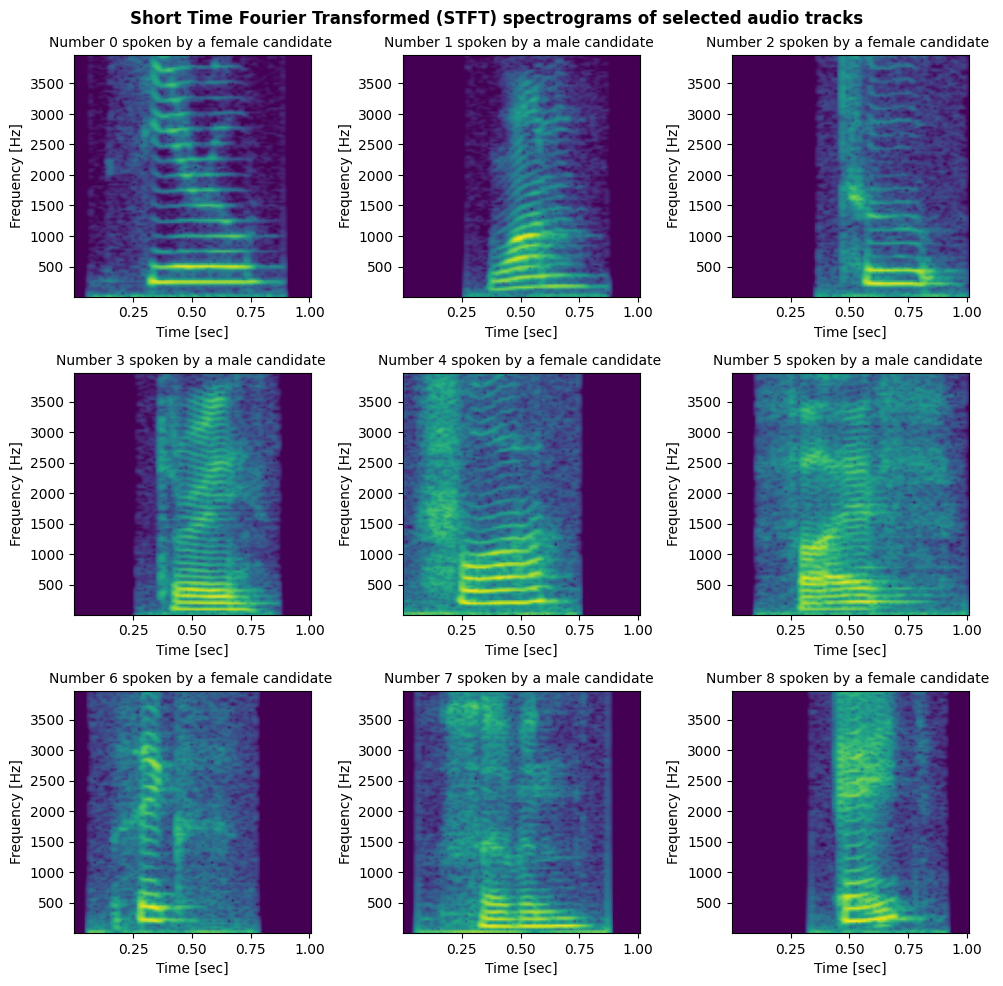

In [ ]:
# The code below takes the same samples for the 0-9 digits by females and males as in previous cell
# and display the spectrograms asscociated with the waveforms.

gender_ = 0
fig2, axs2 = plt.subplots(3, 3, figsize=(10, 10))

# iterating through the digits 0-9
for i, ax in zip(range(0, 10), axs2.ravel()):
    # we want to show different genders in this preview, so alternating genders
    gender_ = 1 - gender_
    # find the next sample with correct gender and digit
    if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
        continue
    index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]
    audio_track = x[index_to_show]
    num_speak = y_num[index_to_show]
    gender_spoke = y_gender[index_to_show]
    gender_spoke = 'male' if gender_spoke == 0 else 'female'
    # the spectrogram is computed through the use of the Short Time Fourier Transform (STFT)
    # see https://en.wikipedia.org/wiki/Short-time_Fourier_transform
    f, t, Zxx = scipy.signal.stft(audio_track, 8000, nperseg=455, noverlap=393, window='hann')
    Zxx_ = np.abs(Zxx[0:227, 2:-1])
    Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
    # after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
    Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)

    #
    f_, t_ = f[:227], t[:227]

    # to be able to fit everything in memory, we'll resize the spectrogram to images of size 128x128
    # this is not strictly necessary here, but when you try to load the entire dataset in memory, that will be
    # useful.
    f_ = resize(f_, (128, ))
    t_ = resize(t_, (128, ))
    Zxx_ = resize(Zxx_, (1, 128, 128))

    ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} candidate ', fontsize=10)
    ax.pcolormesh(t_, f_, Zxx_[0, :, :], shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')

fig2.suptitle(
    'Short Time Fourier Transformed (STFT) spectrograms of selected audio tracks',
    fontsize=12,
    weight='bold',
)
fig2.tight_layout(pad=1)

In [ ]:
# our usual useful functions

class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print(f"Saved model to {filename_base}.json and weights to {filename_base}.h5")

### The problem

You have two tasks:

1. Train two neural nets taking in _raw waveforms_ and predicting either the digit or the gender. The input waveform should be treated as an 1-dimentional-list with a shape of (8000, 1). Individual models should be trained for each task listed below:

  - Task 1A. **Classification of Gender**: the output is a keras catergorised vector that has a shape of (2, 1). For example, [0, 1] indicates class 2 which represents a waveform from a female candidate.
  - Task 1B. **Classification of Spoken Number**: the output is a keras categorised vector that has a shape of (10, 1). For example, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] indicates class 3 which represents a waveform of spoken number 2.

2. Train the neural nets, this time taking the spectrograms as an input. This preprocessing step is commonly considered as a good embedding for representing the audio signal. The spectrograms should be standardised (through cropping) with a shape of [128, 128, 1] (see visualisation sample code above).

  - Task 2A. **Classification of Gender**: the output is a keras categorised vector that has a shape of (2, 1). For example, [0, 1] indicates class 2 which represents a waveform from a female candidate.
  - Task 2B. **Classification of Spoken Number**: the output is a keras categorised vector that has a shape of (10, 1). For example, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] indicates class 3 which represents a waveform of spoken number 2.

---

**IMPORTANT**

For Task 1A, your model should be saved and submitted with the name: **'waveform_gender_model'**

For Task 1B, your model should be saved and submitted with the name: **'waveform_digit_model'**

For Task 2A, your model should be saved and submitted with the name: **'spectrogram_gender_model'**

For Task 2B, your model should be saved and submitted with the name: **'spectrogram_digit_model'**


In [ ]:
# Hints:
#
# Keep track of the shape of your datasets.
#   For Task 1, inputs should be a collection of waveforms of size [25000 x 8000 x 1].
#   For Task 2, inputs should be a collection of spectrograms transformed from the loaded
#               waveforms, with size of [25000 x 128 x 128 x 1].
#
#   For both classificaition tasks, output should be a collection of lists of binary number,
#               with size of [25000 x n_classes x 1].
#
#     * For spectrogram classification tasks, refer to the sample code in
#           this jupyter notebook to understand the methods of transformation.
#
#     * For spectrogram classification tasks, you may need to install the python library
#           'librosa', through the following command line:
#           pip install librosa
#
#     * pay attention to the learning rate scheduling.
#     * You may also think of using pre-trained networks with fine-tuning.

# Reshape and preprocess
X = x.reshape(-1, 8000, 1)
Y = keras.utils.to_categorical(y_gender, num_classes=2)

# Split the data
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.1)

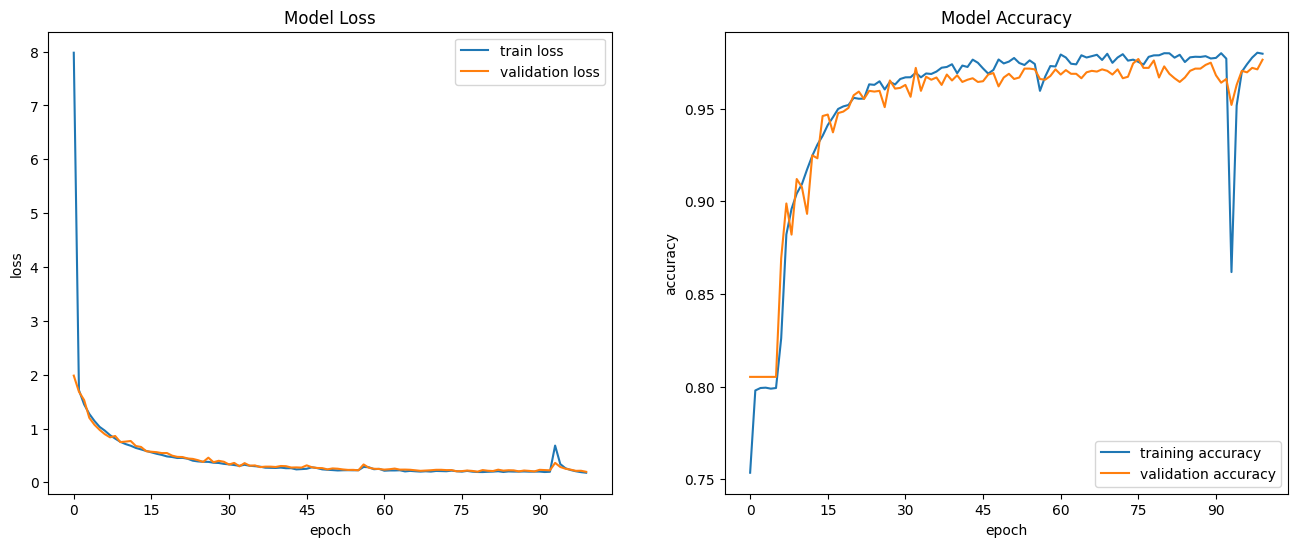

88/88 [==============================] - 6s 68ms/step - loss: 0.1793 - accuracy: 0.9796 - val_loss: 0.1963 - val_accuracy: 0.9764
Saved model to waveform_gender_model.json and weights to waveform_gender_model.h5


In [ ]:
# Task 1A: Gender Classisation on Waveforms


# Regularization factor
reg_factor = 0.005

# Define  input shape
inputs = Input(shape=(8000, 1))

# Convolutional layers with L2 Regularization
x_conv = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(reg_factor))(inputs)
x_conv = MaxPooling1D(pool_size=2)(x_conv)
x_conv = Dropout(0.25)(x_conv)
x_conv = Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(reg_factor))(x_conv)
x_conv = MaxPooling1D(pool_size=2)(x_conv)

# Flatten the output
x_conv = Flatten()(x_conv)

# Dense layers with dropout and L2 Regularization
x_conv = Dense(32, activation='relu', kernel_regularizer=l2(reg_factor))(x_conv)
x_conv = Dropout(0.25)(x_conv)
x_conv = Dense(16, activation='relu', kernel_regularizer=l2(reg_factor))(x_conv)
x_conv = Dropout(0.25)(x_conv)

# Final output layer
predictions = Dense(2, activation='softmax')(x_conv)

# Create the model
model_1A = Model(inputs=inputs, outputs=predictions)

# Configure SGD
# learning_rate = 0.01
# momentum = 0.9
# sgd_optimizer = SGD(learning_rate=learning_rate, momentum=momentum)


# Compile
model_1A.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model_1A.summary()


# Set  number of epochs
num_epochs = 100

# Create an instance of = callback function
pltCallBack = PlotLossAccuracy()

# Train the model
model_1A.fit(X_train, Y_train, batch_size=256, epochs=num_epochs, validation_data=(X_validation, Y_validation), callbacks=[pltCallBack])

# model_1A = # Figure this out
save_model_to_disk(model_1A, 'waveform_gender_model')

In [ ]:
model_1B.summary()

NameError: ignored

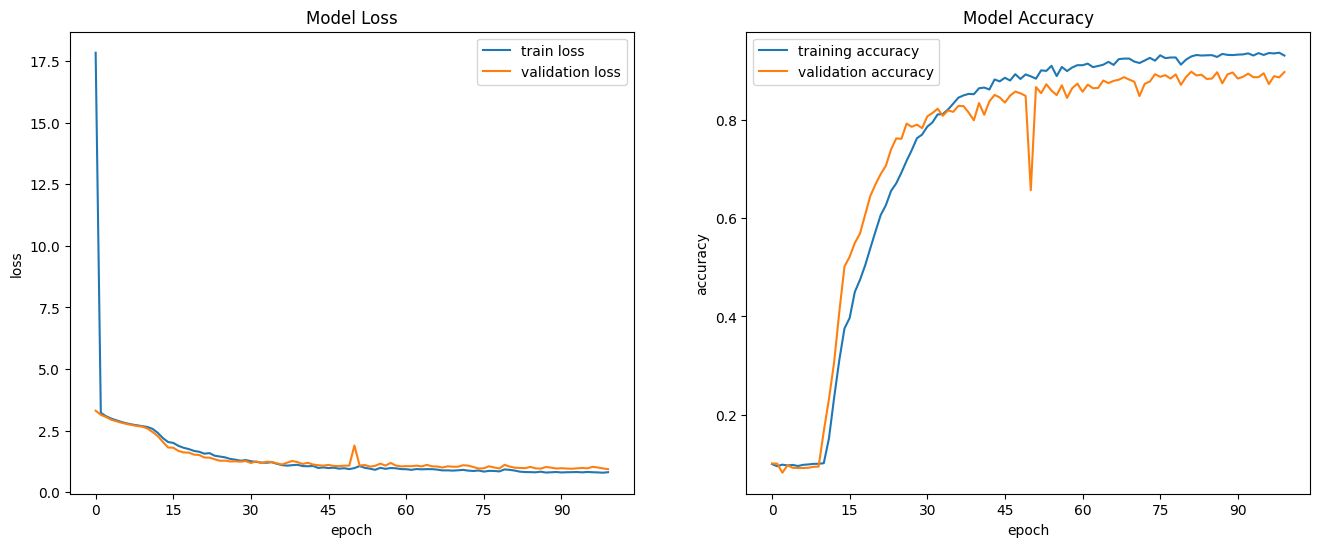

176/176 [==============================] - 6s 36ms/step - loss: 0.8126 - accuracy: 0.9299 - val_loss: 0.9363 - val_accuracy: 0.8964
Saved model to waveform_digit_model.json and weights to waveform_digit_model.h5


In [ ]:
# Task 1B: Digit Classisation on Waveforms

X = x.reshape(-1, 8000, 1)
Y_num = keras.utils.to_categorical(y_num, num_classes=10)

# Split  data
X_train_num, X_validation_num, Y_train_num, Y_validation_num = train_test_split(X, Y_num, test_size=0.1)

# Regularization factor
reg_factor = 0.001

# Define  input shape
inputs = Input(shape=(8000, 1))

# Convolutional layers with L2 Regularization
x_conv = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(reg_factor))(inputs)
x_conv = MaxPooling1D(pool_size=2)(x_conv)
x_conv = Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(reg_factor))(x_conv)
x_conv = MaxPooling1D(pool_size=2)(x_conv)

# Flatten  output
x_conv = Flatten()(x_conv)

# Dense layers with dropout and L2 Regularization
x_conv = Dense(128, activation='relu', kernel_regularizer=l2(reg_factor))(x_conv)
x_conv = Dropout(0.5)(x_conv)
x_conv = Dense(64, activation='relu', kernel_regularizer=l2(reg_factor))(x_conv)
x_conv = Dropout(0.5)(x_conv)

# Final output layer for 10 classes (digits 0-9)
predictions = Dense(10, activation='softmax')(x_conv)

#  model for digit classification
model_1B = Model(inputs=inputs, outputs=predictions)

# Compile
model_1B.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model_1B.summary()

# Set the number of epochs
num_epochs = 100

# Train the model
model_1B.fit(X_train_num, Y_train_num, batch_size= 128, epochs=num_epochs, validation_data=(X_validation_num, Y_validation_num), callbacks=[pltCallBack])

# Save the model
save_model_to_disk(model_1B, 'waveform_digit_model')


In [ ]:
# Task 2A: Gender Classisation on Spectrograms
import numpy as np
import scipy.signal
import librosa
from skimage.transform import resize
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import keras

# Function to convert a batch of waveforms to spectrograms
def convert_waveforms_to_spectrograms(waveforms):
    spectrograms = []
    for waveform in waveforms:
        f, t, Zxx = scipy.signal.stft(waveform, 8000, nperseg=455, noverlap=393, window='hann')
        Zxx_ = np.abs(Zxx[0:227, 2:-1])
        Zxx_ = np.atleast_3d(Zxx_).transpose(2, 0, 1)
        Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)
        Zxx_ = resize(Zxx_, (1, 128, 128))
        spectrograms.append(Zxx_)
    return np.array(spectrograms)

# Assuming 'x' and 'y_gender' are  waveform data and gender labels
X_spectrogram = convert_waveforms_to_spectrograms(x)
X_spectrogram = X_spectrogram.reshape(-1, 128, 128, 1)  # Reshape for CNN

# Preparing labels for categorical_crossentropy
Y_gender = keras.utils.to_categorical(y_gender, num_classes=2)

# Splitting  data
X_train, X_validation, Y_train, Y_validation = train_test_split(X_spectrogram, Y_gender, test_size=0.1)




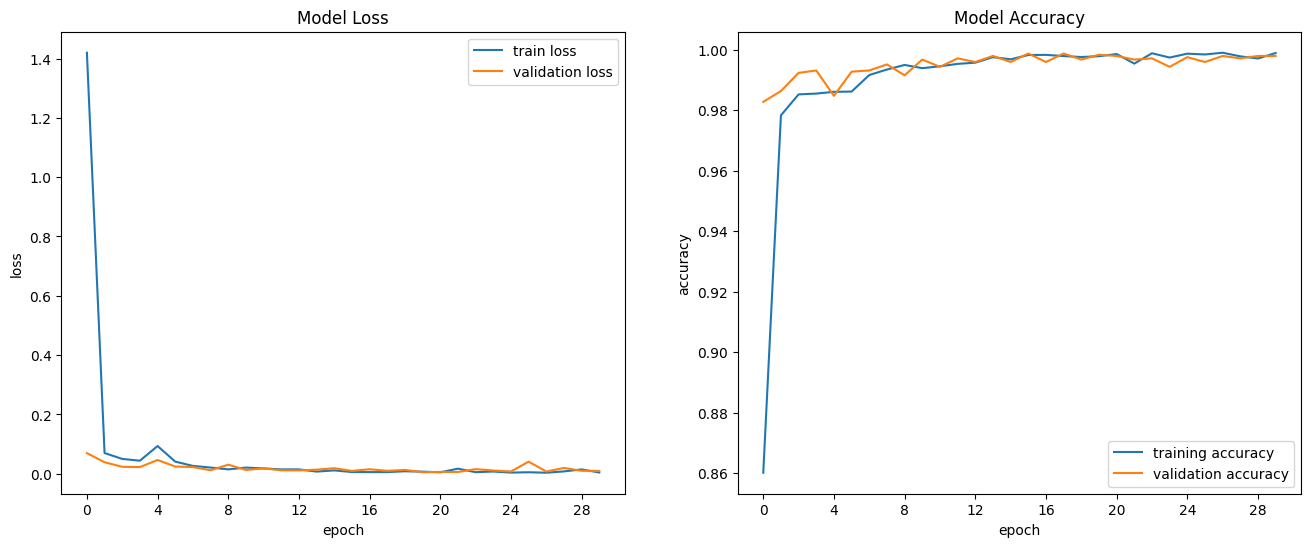

352/352 [==============================] - 5s 13ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.0095 - val_accuracy: 0.9980
Saved model to spectrogram_gender_model.json and weights to spectrogram_gender_model.h5


In [ ]:

inputs = Input(shape=X_train.shape[1:])
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_2A = Model(inputs=inputs, outputs=predictions)

# # Configure the SGD optimizer
# sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# # Compile the model with SGD optimizer
# model_2A.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_2A.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_2A.summary()

# Assuming PlotLossAccuracy is a predefined class or function
pltCallBack = PlotLossAccuracy()
# number of epochs
num_epochs = 50

model_2A.fit(X_train, Y_train, batch_size=64, epochs =30, validation_data=(X_validation, Y_validation),  callbacks=[pltCallBack])

# Save the model
# Assuming save_model_to_disk is a predefined function
save_model_to_disk(model_2A, 'spectrogram_gender_model')

In [ ]:
# import numpy as np
# import keras
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.optimizers import SGD
# from sklearn.model_selection import train_test_split

# # Adjust  spectrograms for ResNet50
# def adjust_spectrograms_for_resnet(spectrograms):
#     adjusted_spectrograms = []
#     for spectrogram in spectrograms:
#         # Resize to (224, 224) and repeat across three channels
#         resized = resize(spectrogram, (224, 224))
#         repeated = np.repeat(resized, 3, axis=-1)
#         adjusted_spectrograms.append(repeated)
#     return np.array(adjusted_spectrograms)

# # Adjust  existing spectrograms
# X_spectrogram_resnet = adjust_spectrograms_for_resnet(X_spectrogram)

# # One-hot encode the digit labels (assuming y_num is the correct label variable)
# Y_digit = keras.utils.to_categorical(y_num, num_classes=10)

# # Split  data
# X_train_spec_digit, X_validation_spec_digit, Y_train_spec_digit, Y_validation_spec_digit = train_test_split(X_spectrogram_resnet, Y_digit, test_size=0.1)

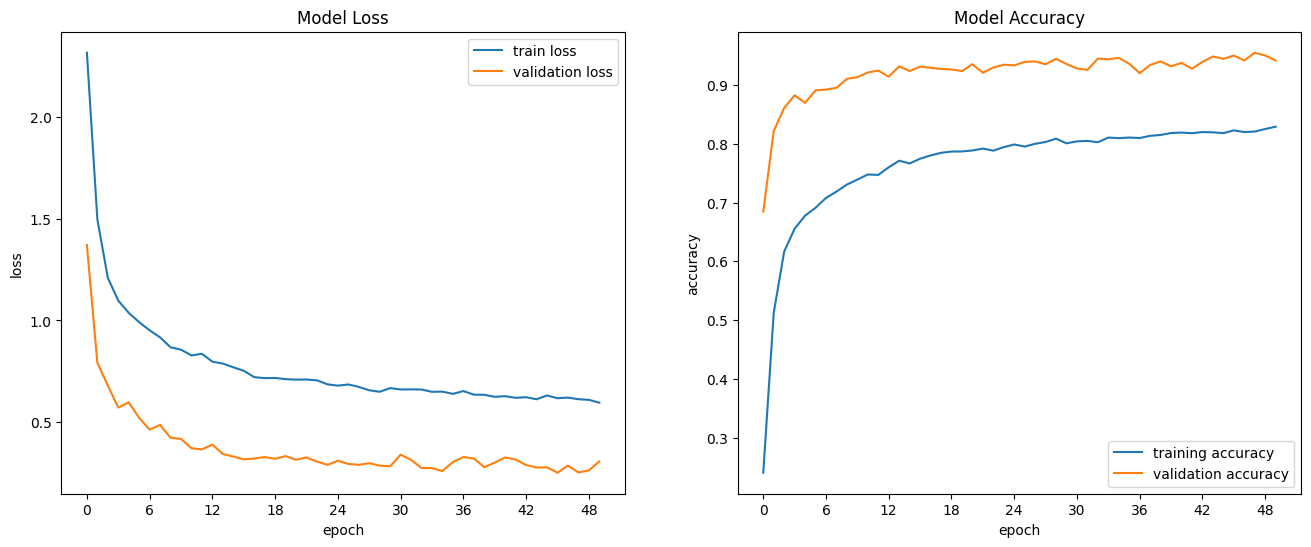

352/352 [==============================] - 5s 14ms/step - loss: 0.5968 - accuracy: 0.8289 - val_loss: 0.3085 - val_accuracy: 0.9416
Saved model to spectrogram_digit_model.json and weights to spectrogram_digit_model.h5


In [ ]:
# # Task 2B: Digit Classisation on Spectrograms
# # first you'll need to convert all waveforms to spectrogram (see sample code in prev cell)


# model_2B = # Figure this out
# save_model_to_disk(model_2B, 'spectrogram_digit_model')

# Import necessary libraries
import numpy as np
import scipy.signal
import librosa
import keras
from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
inputs = Input(shape=X_train.shape[1:])

# One-hot encode the digit labels
Y_digit = keras.utils.to_categorical(y_num, num_classes=10)

# Split  data
X_train_spec_digit, X_validation_spec_digit, Y_train_spec_digit, Y_validation_spec_digit = train_test_split(X_spectrogram, Y_digit, test_size=0.1)

# Define input shape and regularization factor
reg_factor = 0.001

# Build the model
inputs = Input(shape=X_train_spec_digit.shape[1:])
x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(reg_factor))(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg_factor))(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(reg_factor))(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(reg_factor))(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(reg_factor))(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)  # Output layer for 10 digits

model_2B = Model(inputs=inputs, outputs=predictions)

# # Configure the SGD optimizer
# sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Compile
model_2B.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_2B.summary()

# Callback for plotting
pltCallBack = PlotLossAccuracy()

# Train the model
model_2B.fit(X_train_spec_digit, Y_train_spec_digit, batch_size=64, epochs=50,
             validation_data=(X_validation_spec_digit, Y_validation_spec_digit),
             callbacks=[pltCallBack])

# Save the model
save_model_to_disk(model_2B, 'spectrogram_digit_model')

